# PAML for dynamic systems:
### Neural ODE and training methods for continuous-time models
Example system: Nonlinear spring pendulum

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Author: Fabian J. Roth

---

#### In this notebook, you will...

* <span style="color:red">learn something... Todo.</span>

In [1]:
def is_colab():
    """Determine if the code is running in Google Colab."""
    try:
        import google.colab

        return True
    except ImportError:
        return False


if is_colab():
    print("Running in Google Colab, trying to install LecturePhysicsAwareML...")
    !git clone --depth 1 https://github.com/Drenderer/LecturePhysicsAwareML.git
    %cd LecturePhysicsAwareML/dynamic_modeling
    %pip install -e .
    print(
        "Make sure to restert the session after installation (Runtime > Restart Session)."
    )
else:
    print(
        "Not running in Google Colab. \nPlease install the package manually if needed. If you are using pip, run:\n>>> pip install -e .\nin the dynamic_modeling directory."
    )

Not running in Google Colab. 
Please install the package manually if needed. If you are using pip, run:
>>> pip install -e .
in the dynamic_modeling directory.


In [ ]:
from dynamic_modeling import (
    ODESolver,
    TwoMassOscillator,
    plot_trajectory,
)
import klax

import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import optax

from jaxtyping import PRNGKeyArray, Array

import matplotlib.pyplot as plt

## 1.1 Data generation

In [ ]:
two_mass_oscillator = TwoMassOscillator(m1=1.0, m2=1.0, k1=1.0, k2=0.5)
true_system = ODESolver(two_mass_oscillator)

n = 20  # Number of trajectories

key = jr.key(0)
r_key, θ_key = jr.split(key)
ts = jnp.linspace(0, 10, 500)

# Generate random initial conditions for training
q0s = jr.uniform(r_key, (n, 2), minval=-1.0, maxval=1.0)
q_t0s = jnp.zeros_like(q0s)
y0s = jnp.concat([q0s, q_t0s], axis=-1)
ys = jax.vmap(true_system, in_axes=(None, 0))(ts, y0s)

# Make derivative data
ys_flat = jnp.reshape(ys, (-1, ys.shape[-1]))
ys_t_flat = jax.vmap(two_mass_oscillator, (None, 0))(None, ys_flat)

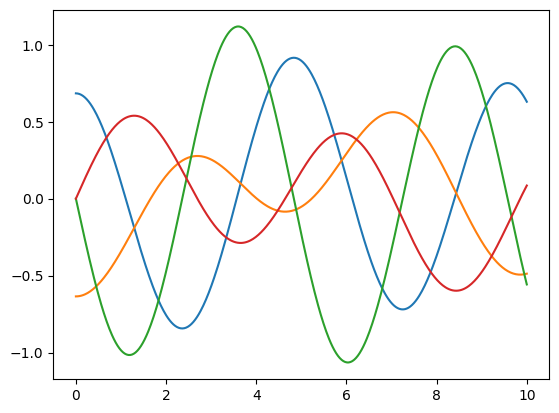

In [5]:
plt.plot(ts, ys[0])

## 2. Training: Derivative vs. Trajectory fitting

In [7]:
# Test training of a neural ODE
key = jr.key(0)
model_key, loader_key = jr.split(key)


class NODEDerivative(eqx.Module):
    mlp: klax.nn.MLP

    def __init__(self, *, key: PRNGKeyArray):
        self.mlp = klax.nn.MLP(
            in_size=4,
            out_size=4,
            width_sizes=[32, 32],
            weight_init=jax.nn.initializers.normal(stddev=0.1),
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        return self.mlp(y)


def derivative_loss(model: ODESolver, data, batch_axis):
    """Evaluate the models derivative function and compare it to the true derivative."""
    ys, ys_t = data
    ys_t_pred = jax.vmap(model.func, in_axes=0)(None, ys)
    return jnp.mean(jnp.square(ys_t_pred - ys_t))


def trajectory_loss(model: ODESolver, data, batch_axis):
    """Compute the models predicted trajectory and compare it to the true trajectory."""
    ts, ys = data
    ys_pred = jax.vmap(model, in_axes=batch_axis)(ts, ys[:, 0])
    return jnp.mean(jnp.square(ys_pred - ys))


In [ ]:
# Derivative fitting
node_deriv = NODEDerivative(key=model_key)
node_ = ODESolver(node_deriv)
node_, hist = klax.fit(
    node_,
    (ys_flat, ys_t_flat),
    batch_size=32,
    steps=10_000,
    loss_fn=derivative_loss,
    key=loader_key,
)
hist.plot()

In [ ]:
# Trajectory fitting

node_deriv = NODEDerivative(key=model_key)
node = ODESolver(node_deriv)

node, hist = klax.fit(
    node,
    (ts, ys),
    batch_axis=(None, 0),
    batch_size=16,
    steps=10_000,
    loss_fn=trajectory_loss,
    optimizer=optax.adam(1e-3),
    history=klax.HistoryCallback(log_every=100),
    key=loader_key,
)
hist.plot()

In [ ]:
y0_eval = ys[0, 0]  # jnp.array([0.8, -0.9, 0.0, 0.0])  # Initial condition for evaluation
ts_eval = jnp.linspace(0, 50, 1000)
ys_pred = node(ts_eval, y0_eval)
ys_pred_ = node_(ts_eval, y0_eval)
ys_true = true_system(ts_eval, y0_eval)

fig, ax = plt.subplots(figsize=(20, 5))
plot_trajectory(ts_eval, ys_pred, color="green", label="Predicted (TF)")
plot_trajectory(ts_eval, ys_pred_, color="red", label="Predicted (DF)")
plot_trajectory(ts_eval, ys_true, color="black", label="True", lw=2)
plt.show()

In [ ]:
E_true = two_mass_oscillator.compute_energy(ys_true)
E_predicted_ = two_mass_oscillator.compute_energy(ys_pred_)
E_predicted = two_mass_oscillator.compute_energy(ys_pred)
plt.plot(ts_eval, E_true, label="True Energy", color="black")
plt.plot(ts_eval, E_predicted_, label="Predicted Energy", color="red")
plt.plot(ts_eval, E_predicted, label="Predicted Energy", color="blue")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

## 2.2 Augemented Neural ODE
GOAL: Show that here only trajectory fitting is possible. 

Imageine we only have 1 coordinate as data.

In [ ]:
ys_truncated = ys[:, :, :2]
ys_truncated.shape

In [ ]:
node_deriv = NODEDerivative(key=model_key)
augmented_node = ODESolver(
    node_deriv, augmentation=2
)  # Add to augmented states to the model

augmented_node, hist = klax.fit(
    augmented_node,
    (ts, ys_truncated),
    batch_axis=(None, 0),
    steps=80_000,
    loss_fn=trajectory_loss,
    optimizer=optax.adam(1e-3),
    history=hist,
    key=loader_key,
)
hist.plot()

In [ ]:
y0_eval = ys[0, 0]  # jnp.array([0.8, -0.9, 0.0, 0.0])  # Initial condition for evaluation
ts_eval = jnp.linspace(0, 10, 1000)
ys_pred = augmented_node(ts_eval, y0_eval[:2])
ys_true = true_system(ts_eval, y0_eval)

fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(ts_eval, ys_pred, color="green", label="Predicted")
plot_trajectory(ts_eval, ys_true, color="black", label="True", lw=2)
plt.show()

## 3. Hamiltonian NN: Energy based modeling

In [18]:
two_mass_oscillator = TwoMassOscillator(m1=1.0, m2=1.0, k1=1.0, k2=0.5)
true_system = ODESolver(two_mass_oscillator)

n = 20  # Number of trajectories

key = jr.key(0)
r_key, θ_key = jr.split(key)
ts = jnp.linspace(0, 10, 500)

# Generate random initial conditions for training
q0s = jr.uniform(r_key, (n, 2), minval=-1.0, maxval=1.0)
q_t0s = jnp.zeros_like(q0s)
y0s = jnp.concat([q0s, q_t0s], axis=-1)
ys = jax.vmap(true_system, in_axes=(None, 0))(ts, y0s)

# Make derivative data
ys_flat = jnp.reshape(ys, (-1, ys.shape[-1]))
ys_t_flat = jax.vmap(two_mass_oscillator, (None, 0))(None, ys_flat)

In [19]:
class HamiltonianNN(eqx.Module):
    hamiltonian: klax.nn.MLP

    def __init__(self, *, key: PRNGKeyArray):
        self.hamiltonian = klax.nn.MLP(
            in_size=4,
            out_size="scalar",
            width_sizes=[32, 32],
            # weight_init=jax.nn.initializers.normal(stddev=0.1),
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        grad_H = jax.grad(self.hamiltonian)(y)
        dH_dq, dH_dp = jnp.split(grad_H, 2, axis=-1)
        dq_dt = dH_dp
        dp_dt = -dH_dq
        return jnp.concatenate([dq_dt, dp_dt], axis=-1)
    
class LagrangianNN(eqx.Module):
    lagrangian: klax.nn.MLP

    def __init__(self, *, key: PRNGKeyArray):
        self.lagrangian = klax.nn.MLP(
            in_size=4,
            out_size="scalar",
            width_sizes=[32, 32],
            weight_init=jax.nn.initializers.normal(stddev=0.1),
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        q, q_t = jnp.split(y, 2, axis=-1)

        # Redefine the Lagrangian in terms of the generalized coordinates and velocities.
        # This is necessary to differentiate with respect to q and q_t.
        def _lagrangian(q, q_t):
            y = jnp.concat([q, q_t], axis=-1)
            return self.lagrangian(y)

        q_tt = jax.numpy.linalg.pinv(jax.hessian(_lagrangian, 1)(q, q_t)) @ (
                jax.grad(_lagrangian, 0)(q, q_t)
                - jax.jacfwd(jax.grad(_lagrangian, 1), 0)(q, q_t) @ q_t
            )
        return jnp.concat([q_t, q_tt])

Step: 0, Loss: 7.678e-01
Step: 100, Loss: 7.884e-02
Step: 200, Loss: 1.285e-02
Step: 300, Loss: 4.643e-03
Step: 400, Loss: 2.530e-03
Step: 500, Loss: 1.919e-03
Step: 600, Loss: 1.708e-03
Step: 700, Loss: 1.570e-03
Step: 800, Loss: 1.477e-03
Step: 900, Loss: 1.371e-03
Step: 1000, Loss: 1.271e-03
Step: 1100, Loss: 1.207e-03
Step: 1200, Loss: 1.122e-03
Step: 1300, Loss: 1.049e-03
Step: 1400, Loss: 9.937e-04
Step: 1500, Loss: 9.263e-04
Step: 1600, Loss: 8.742e-04
Step: 1700, Loss: 8.346e-04
Step: 1800, Loss: 7.878e-04
Step: 1900, Loss: 7.352e-04
Step: 2000, Loss: 7.017e-04
Step: 2100, Loss: 6.560e-04
Step: 2200, Loss: 6.246e-04
Step: 2300, Loss: 5.785e-04
Step: 2400, Loss: 5.638e-04
Step: 2500, Loss: 5.158e-04
Step: 2600, Loss: 5.018e-04
Step: 2700, Loss: 4.476e-04
Step: 2800, Loss: 5.127e-04
Step: 2900, Loss: 3.990e-04
Step: 3000, Loss: 4.776e-04
Step: 3100, Loss: 3.718e-04
Step: 3200, Loss: 3.422e-04
Step: 3300, Loss: 3.493e-04
Step: 3400, Loss: 3.206e-04
Step: 3500, Loss: 3.071e-04
Step

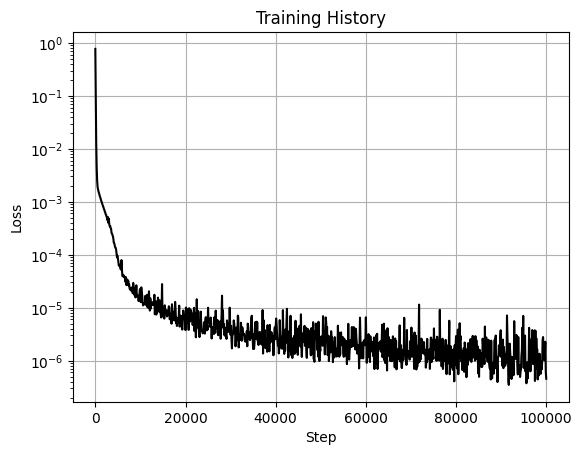

In [20]:
key = jr.key(0)
model_key, loader_key = jr.split(key)

hnn_derivative = HamiltonianNN(key=model_key)
hnn = ODESolver(hnn_derivative)

hnn, hist = klax.fit(
    hnn,
    (ys_flat, ys_t_flat),
    steps=50_000,
    loss_fn=derivative_loss,
    key=loader_key,
)
hist.plot()

Step: 0, Loss: 5.268e+02
Step: 100, Loss: 1.258e+01
Step: 200, Loss: 1.498e+00
Step: 300, Loss: 5.426e-01
Step: 400, Loss: 4.944e-01
Step: 500, Loss: 4.834e-01
Step: 600, Loss: 4.678e-01
Step: 700, Loss: 4.538e-01
Step: 800, Loss: 4.417e-01
Step: 900, Loss: 4.238e-01
Step: 1000, Loss: 4.086e-01
Step: 1100, Loss: 3.935e-01
Step: 1200, Loss: 3.782e-01
Step: 1300, Loss: 3.616e-01
Step: 1400, Loss: 3.463e-01
Step: 1500, Loss: 3.311e-01
Step: 1600, Loss: 3.150e-01
Step: 1700, Loss: 2.979e-01
Step: 1800, Loss: 2.814e-01
Step: 1900, Loss: 2.676e-01
Step: 2000, Loss: 2.490e-01
Step: 2100, Loss: 2.317e-01
Step: 2200, Loss: 2.173e-01
Step: 2300, Loss: 1.985e-01
Step: 2400, Loss: 1.808e-01
Step: 2500, Loss: 1.643e-01
Step: 2600, Loss: 1.455e-01
Step: 2700, Loss: 1.306e-01
Step: 2800, Loss: 1.103e-01
Step: 2900, Loss: 9.441e-02
Step: 3000, Loss: 7.787e-02
Step: 3100, Loss: 6.336e-02
Step: 3200, Loss: 5.138e-02
Step: 3300, Loss: 4.392e-02
Step: 3400, Loss: 3.546e-02
Step: 3500, Loss: 3.106e-02
Step

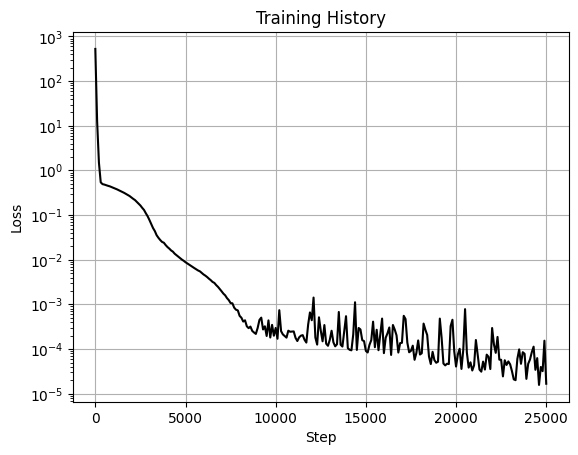

In [21]:
key = jr.key(0)
model_key, loader_key = jr.split(key)

lnn_derivative = LagrangianNN(key=model_key)
lnn = ODESolver(lnn_derivative)

lnn, hist = klax.fit(
    lnn,
    (ys_flat, ys_t_flat),
    steps=25_000,
    loss_fn=derivative_loss,
    optimizer=optax.adam(1e-4),
    key=loader_key,
)

hist.plot()

In [22]:
y0_eval = ys[0, 0]  # jnp.array([0.8, -0.9, 0.0, 0.0])  # Initial condition for evaluation
ts_eval = jnp.linspace(0, 25, 1000)
ys_true = true_system(ts_eval, y0_eval)
ys_hnn = hnn(ts_eval, y0_eval)
ys_lnn = lnn(ts_eval, y0_eval)

energy_true = jax.vmap(two_mass_oscillator.get_energy)(ys_true)
energy_hnn  = jax.vmap(two_mass_oscillator.get_energy)(ys_hnn)
energy_lnn  = jax.vmap(two_mass_oscillator.get_energy)(ys_lnn)

hamiltonian_hnn = jax.vmap(hnn.func.hamiltonian)(ys_hnn)

In [23]:
def plot_energy(ts, energy, ax=None, **kwargs):
    if energy.ndim != 1:
        raise ValueError("energy must be a 1D array with the same shape as ts.")

    if ax is None:
        ax = plt.gca()

    kwargs.setdefault("label", "Energy")
    kwargs.setdefault("ls", "-")
    ax.plot(ts, energy, **kwargs)
    ax.set(
        xlabel="Time t",
        ylabel="Energy",
        title="Spring Pendulum Energy Over Time",
    )
    ax.legend()

    return ax

def set_minimum_axis_limits(ax, min_span = 1e-3):
    # Get current axis limits
    ymin, ymax = ax.get_ylim()

    # Enforce minimum span on y-axis
    if ymax - ymin < min_span:
        center = (ymax + ymin) / 2
        ymin = center - min_span / 2
        ymax = center + min_span / 2
        ax.set_ylim(ymin, ymax)

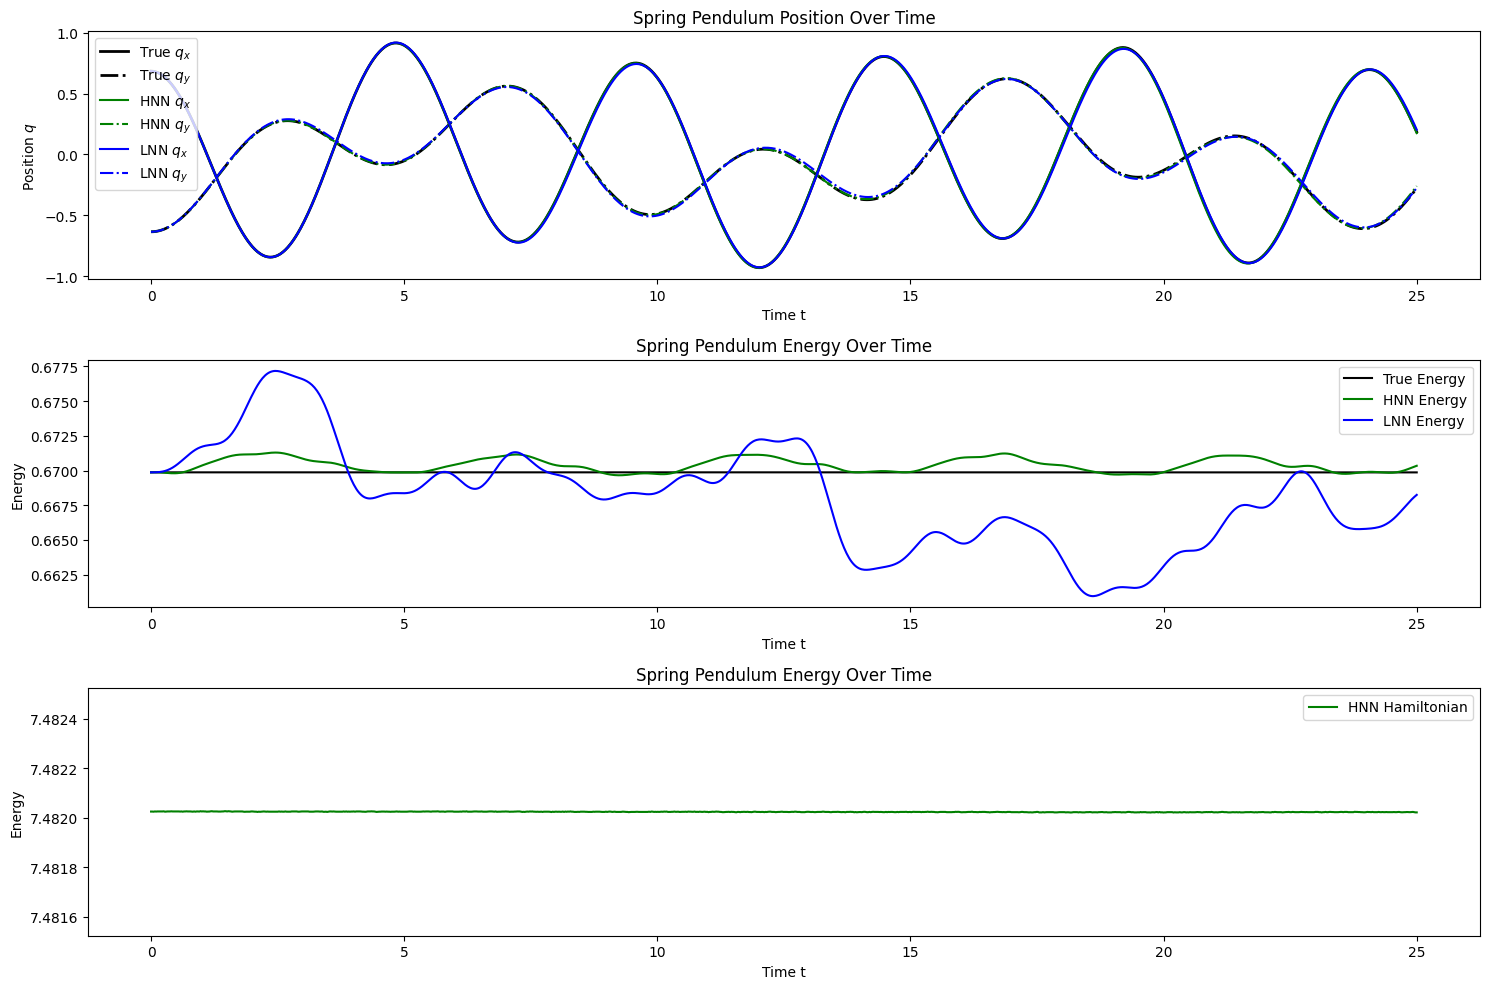

In [24]:
fig, axes = plt.subplots(3,1,figsize=(15, 10))
plot_trajectory(ts_eval, ys_true, ax=axes[0], color="black", label="True", lw=2)
plot_trajectory(ts_eval, ys_hnn, ax=axes[0], color="green", label="HNN")
plot_trajectory(ts_eval, ys_lnn, ax=axes[0], color="blue", label="LNN")

plot_energy(ts_eval, energy_true, ax=axes[1], label="True Energy", color="black")
plot_energy(ts_eval, energy_hnn, ax=axes[1], label="HNN Energy", color="green")
plot_energy(ts_eval, energy_lnn, ax=axes[1], label="LNN Energy", color="blue")

plot_energy(ts_eval, hamiltonian_hnn, ax=axes[2], label="HNN Hamiltonian", color="green")
set_minimum_axis_limits(axes[2])
plt.tight_layout()
plt.show()